In [1]:
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import aplpy
import numpy as np
import astropy.units as u
import time 
import warnings 
import matplotlib as mpl

plt.style.use('paper.mplstyle')
warnings.filterwarnings('ignore')

In [2]:
def custom_sort(arr, text='mrs0'):

    arr_new = [np.float32(item.replace(text,'')) for item in arr]
    arr_new = np.array(arr_new)

    arr_sort = np.sort(arr_new)
    arr_argsort = np.argsort(arr_new)

    return(arr_sort, arr_argsort)

In [3]:
def remove_padding(data):

    data = np.squeeze(data)
    
    # Find valid data indices along each axis
    valid_x = np.where(np.nansum(data, axis=0)!=0)[0]
    valid_y = np.where(np.nansum(data, axis=1)!=0)[0]
    
    # Crop the data array
    cropped_data = data[valid_y[0]:valid_y[-1]+1, valid_x[0]:valid_x[-1]+1]
    return cropped_data

In [4]:
which = 'gaussians'

# which_time = ''
# which_time = '_6totaltime'
# which_time = '_60totaltime'
# which_time = '_6totaltime_flagged'
# which_time = '_60totaltime_flagged'

# which_times = ['_6totaltime', '_60totaltime', '_6totaltime_flagged', '_60totaltime_flagged']
which_times = ['_6totaltime']

In [5]:
bbox = dict(facecolor='whitesmoke',  alpha=0.95, boxstyle='round')

In [6]:
# confs = ['conf1', 'conf2', 'conf3', 'conf4', 'conf5', 'conf6', 'conf7', 'conf8', 'conf9', 'conf10']
confs = ['conf1']

In [7]:
ra = 180.0
dec = -23.0
width = 0.02
height = 0.02
size = 0.02

[INFO] File sim: conf1_2.9mrs0.fits
[INFO] File sim: conf1_5.7mrs0.fits
[INFO] File sim: conf1_8.6mrs0.fits
[INFO] File sim: conf1_11.4mrs0.fits
[INFO] File sim: conf1_14.2mrs0.fits
[INFO] File sim: conf1_17.1mrs0.fits
[INFO] File sim: conf1_19.9mrs0.fits
[INFO] File sim: conf1_22.8mrs0.fits
[INFO] File sim: conf1_25.7mrs0.fits
[INFO] File sim: conf1_28.5mrs0.fits
[INFO] File sim: conf1_31.4mrs0.fits
[INFO] File sim: conf1_34.2mrs0.fits
[INFO] File sim: conf1_37.1mrs0.fits
[INFO] File sim: conf1_39.9mrs0.fits
[INFO] File sim: conf1_42.8mrs0.fits


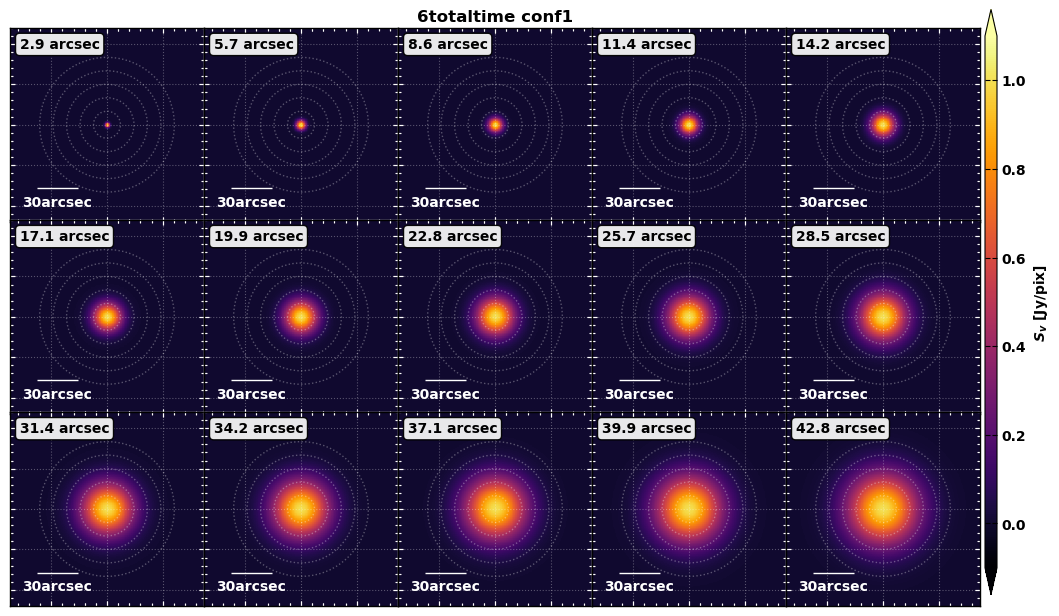

In [10]:
for which_time in which_times:

    dir_sim = f'./../data/{which}_input/'
    dir_obs = f'./../data/{which}_observed{which_time}/'

    files_sim = glob(f'{dir_sim}*.fits')
    files_obs = glob(f'{dir_obs}*.pbcor.Jyperpix.fits')

    files_sim.sort()
    files_obs.sort()

    start_total = time.time()
    for conf in confs: 

        files_sim = glob(f'{dir_sim}{conf}_*.fits')
        files_obs = glob(f'{dir_obs}{conf}_*.pbcor.Jyperpix.fits')
        files_sim.sort()
        files_obs.sort()

        n = 15
        conf_arr = ['']*n
        wide_arr = ['']*n

        for i, file_sim in enumerate(files_sim):
            
            start = time.time()

            conf_file = file_sim.split('/')[-1].split('_')[0]
            wide_file = file_sim.split('/')[-1].split('_')[-1].replace('.fits', '')

            conf_arr[i] = conf
            wide_arr[i] = wide_file

        fig1 = plt.figure(figsize=(10, 6.5))
        
        title1 = which_time.replace('_', ' ')[1:]
        title2 = conf_arr[0]
        fig1.suptitle('%s %s' %(title1, title2), fontweight='bold', y=0.95)

        wide_arr_sort, wide_arr_argsort = custom_sort(wide_arr)

        for i, j in enumerate(wide_arr_argsort):
            
            # if i >1: 
            #     continue

            start = time.time()

            file_sim = files_sim[j]

            print('[INFO] File sim: %s' %file_sim.split('/')[-1])

            hdu_sim = fits.open(file_sim)[0]
            hdu_sim.data = np.squeeze(hdu_sim.data)
            del hdu_sim.header['*3*'] 
            del hdu_sim.header['*4*'] 

            ax1 = aplpy.FITSFigure(hdu_sim, subplot=(3, 5, i+1), figure=fig1)

            vmin, vmax = np.nanpercentile(hdu_sim.data, (0, 100.0))
            vmin, vmax = -0.1, 1.1
            ax1.show_colorscale(vmin=vmin, vmax=vmax, cmap='inferno')

            ax1.recenter(ra, dec, size)
            ax1.axis_labels.hide()
            ax1.tick_labels.hide()

            label = 'conf'
            ax1.add_label(0.05, 0.95, wide_arr[j].replace('mrs0', ' arcsec'),  ha='left', va='top', size=10, bbox = bbox, relative=True)
            
            ax1.add_scalebar(30*u.arcsec, corner='bottom left')
            ax1.scalebar.set_label('30arcsec')
            ax1.scalebar.set_color('white')

            ax1.set_nan_color('lightgrey')
            ax_plot = fig1.get_axes()[-1]
            ax_plot.grid(True, alpha=0.3, ls=':', color='white')

            for i in range(1,6):
                ax1.show_circles(ra, dec, i*(10/3600), ls=':', alpha=0.3, color='white')

        # Adding the colorbar
        axes_list = fig1.get_axes()
        cbaxes_ = axes_list[0].scatter([0,0],[0,0],cmap='inferno',c=[vmin, vmax],s=0)
        cbaxes = fig1.add_axes([0.99, 0.05, 0.012, 0.9])  
        norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
        cb = plt.colorbar(cbaxes_, cax=cbaxes, norm=norm, extend='both')
        cb.ax.tick_params(labelsize=10) 
        cb.set_label(label='$S_v$ [Jy/pix]',weight='bold',fontsize=10)

        ax_cbar = fig1.get_axes()[-1]
        ax_cbar.yaxis.set_ticks_position('both')
        ax_cbar.set_rasterized(True)

        fig1.tight_layout(h_pad=0, w_pad=0)
        # fig1.tight_layout(h_pad=0.05, w_pad=0.01)
        fig1.savefig(f'./../figs/maps_{which}{which_time}_{conf_arr[i]}_sim.pdf', dpi=300, bbox_inches='tight', transparent=False)
        fig1.savefig(f'./../figs/maps_{which}{which_time}_{conf_arr[i]}_sim.png', dpi=300, bbox_inches='tight', transparent=False)

[INFO] File sim: conf1_2.9mrs0_project_6totaltime.alma.cycle5.1.image.pbcor.Jyperpix.fits
[INFO] File sim: conf1_5.7mrs0_project_6totaltime.alma.cycle5.1.image.pbcor.Jyperpix.fits
[INFO] File sim: conf1_8.6mrs0_project_6totaltime.alma.cycle5.1.image.pbcor.Jyperpix.fits
[INFO] File sim: conf1_11.4mrs0_project_6totaltime.alma.cycle5.1.image.pbcor.Jyperpix.fits
[INFO] File sim: conf1_14.2mrs0_project_6totaltime.alma.cycle5.1.image.pbcor.Jyperpix.fits
[INFO] File sim: conf1_17.1mrs0_project_6totaltime.alma.cycle5.1.image.pbcor.Jyperpix.fits
[INFO] File sim: conf1_19.9mrs0_project_6totaltime.alma.cycle5.1.image.pbcor.Jyperpix.fits
[INFO] File sim: conf1_22.8mrs0_project_6totaltime.alma.cycle5.1.image.pbcor.Jyperpix.fits
[INFO] File sim: conf1_25.7mrs0_project_6totaltime.alma.cycle5.1.image.pbcor.Jyperpix.fits
[INFO] File sim: conf1_28.5mrs0_project_6totaltime.alma.cycle5.1.image.pbcor.Jyperpix.fits
[INFO] File sim: conf1_31.4mrs0_project_6totaltime.alma.cycle5.1.image.pbcor.Jyperpix.fits
[I

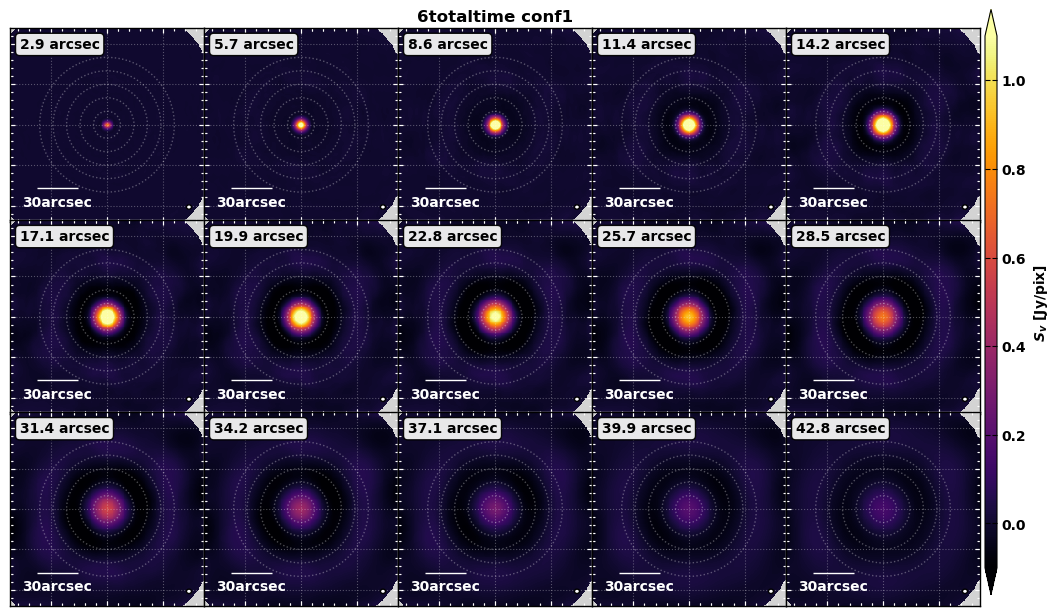

In [11]:
for which_time in which_times:

    dir_sim = f'./../data/{which}_input/'
    dir_obs = f'./../data/{which}_observed{which_time}/'

    files_sim = glob(f'{dir_sim}*.fits')
    files_obs = glob(f'{dir_obs}*.pbcor.Jyperpix.fits')

    files_sim.sort()
    files_obs.sort()

    start_total = time.time()
    for conf in confs: 

        files_sim = glob(f'{dir_sim}{conf}_*.fits')
        files_obs = glob(f'{dir_obs}{conf}_*.pbcor.Jyperpix.fits')
        files_sim.sort()
        files_obs.sort()

        n = 15
        conf_arr = ['']*n
        wide_arr = ['']*n

        for i, file_sim in enumerate(files_sim):
            
            start = time.time()

            conf_file = file_sim.split('/')[-1].split('_')[0]
            wide_file = file_sim.split('/')[-1].split('_')[-1].replace('.fits', '')

            conf_arr[i] = conf
            wide_arr[i] = wide_file

        fig1 = plt.figure(figsize=(10, 6.5))
        
        title1 = which_time.replace('_', ' ')[1:]
        title2 = conf_arr[0]
        fig1.suptitle('%s %s' %(title1, title2), fontweight='bold', y=0.95)

        wide_arr_sort, wide_arr_argsort = custom_sort(wide_arr)

        for i, j in enumerate(wide_arr_argsort):
            
            start = time.time()

            file_obs = files_obs[j]

            print('[INFO] File sim: %s' %file_obs.split('/')[-1])

            hdu_obs = fits.open(file_obs)[0]
            hdu_obs.data = np.squeeze(hdu_obs.data)
            # hdu_obs.data = remove_padding(hdu_obs.data)
            del hdu_obs.header['*3*'] 
            del hdu_obs.header['*4*'] 

            ax1 = aplpy.FITSFigure(hdu_obs, subplot=(3, 5, i+1), figure=fig1)

            # vmin, vmax = np.nanpercentile(hdu_obs.data, (0, 100.0))
            vmin, vmax = -0.1, 1.1
            ax1.show_colorscale(vmin=vmin, vmax=vmax, cmap='inferno')

            ax1.recenter(ra, dec, size)
            ax1.axis_labels.hide()
            ax1.tick_labels.hide()

            ax1.add_label(0.05, 0.95, wide_arr[j].replace('mrs0', ' arcsec'),  ha='left', va='top', size=10, bbox = bbox, relative=True)

            ax1.add_beam()
            ax1.beam.set_color('white')
            ax1.beam.set_edgecolor('black')
            ax1.beam.set_corner('bottom right')

            ax1.add_scalebar(30*u.arcsec, corner='bottom left')
            ax1.scalebar.set_label('30arcsec')
            ax1.scalebar.set_color('white')

            ax1.set_nan_color('lightgrey')
            ax_plot = fig1.get_axes()[-1]
            ax_plot.grid(True, alpha=0.3, ls=':', color='white')

            for i in range(1,6):
                ax1.show_circles(ra, dec, i*(10/3600), ls=':', alpha=0.3, color='white')

        # Adding the colorbar
        axes_list = fig1.get_axes()
        cbaxes_ = axes_list[0].scatter([0,0],[0,0],cmap='inferno',c=[vmin, vmax],s=0)
        cbaxes = fig1.add_axes([0.99, 0.05, 0.012, 0.9])  
        norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
        cb = plt.colorbar(cbaxes_, cax=cbaxes, norm=norm, extend='both')
        cb.ax.tick_params(labelsize=10) 
        cb.set_label(label='$S_v$ [Jy/pix]',weight='bold',fontsize=10)

        ax_cbar = fig1.get_axes()[-1]
        ax_cbar.yaxis.set_ticks_position('both')
        ax_cbar.set_rasterized(True)

        fig1.tight_layout(h_pad=0, w_pad=0)
        fig1.savefig(f'./../figs/maps_{which}{which_time}_{conf_arr[i]}_obs.pdf', dpi=300, bbox_inches='tight', transparent=False)
        fig1.savefig(f'./../figs/maps_{which}{which_time}_{conf_arr[i]}_obs.png', dpi=300, bbox_inches='tight', transparent=False)